## Wstęp do NeRF
W tym notebooku przedstawimy czym jest NeRF, do czego służy oraz jakie techniki są używane aby usprawnić jego działanie.

### Spis treści
1. [Czym jest NeRF?](#Czym-jest-NeRF?)
1. [Dataset potrzebny do trenowania NeRF'a](#Dataset-potrzebny-do-trenowania-NeRF'a)
2. [Przetwarzanie danych przez MLP](#Przetwarzanie-danych-przez-MLP)
3. [Czym jest input dla NeRF?](#Czym-jest-input-dla-NeRF?)
4. [Renderowanie obrazu](#Renderowanie-obrazu)
5. [Proces trenowania](#Proces-trenowania)
6. [Usprawnienie modelu](#Usprawnienie-modelu)
7. [Rezultaty](#Rezultaty)
8. [Podsumowanie i nasze wnioski](#Podsumowanie-i-nasze-wnioski)
10. [Bibliografia](#Bibliografia)


#### Czym jest NeRF?

NeRF to akronim od Neural Radiance Fields for View Synthesis, co można przetłumaczyć jako Neuronowe Pola Radiacyjne do syntezy widoków.

Jest to technika wykorzystująca głębokie sieci neuronowe do generowania realistycznych renderów scen trójwymiarowych. Głównym celem NeRF jest modelowanie radiance field, czyli funkcji reprezentującej radiancję światła w trójwymiarowej przestrzeni. Prościej mówiąc, NeRF jest w stanie wygenerować fotorealistyczne obrazy scen 3D, na podstawie danych treningowych z rzeczywistych scen. 

Tradycyjne metody renderowania 3D, takie jak ray tracing czy rasterization, mają swoje ograniczenia w generowaniu szczegółowych i fotorealistycznych obrazów. NeRF stanowi innowacyjne podejście, umożliwiając renderowanie scen 3D poprzez uczenie głębokich sieci neuronowych na podstawie danych treningowych z rzeczywistych scen.

<br>
<br>
<!-- <div style="display: flex; flex-direction: horizontal;">
    <img src="https://uploads-ssl.webflow.com/51e0d73d83d06baa7a00000f/5e700ef6067b43821ed52768_pipeline_website-01-p-800.png" alt="NeRF" width="1000" style="background-color:white;">
</div>
<figcaption>Fig.1 - przetwarzanie danych przez model [1].</figcaption>
<div style="display: flex; flex-direction: horizontal;">
    <img src="src/promienie_gestosc.png" alt="NeRF" width="1000">
</div>
<figcaption>Fig.2 - renderowanie koloru i loss function [1]</figcaption> -->
<div style="display: flex; justify-content: center;">
    <img src="src/nerf_lego.gif" width="600">
</div>
<figcaption style="display: flex; justify-content: center;">Fig.1 - zestawienie renderów NeRF'a</figcaption>


### Dataset potrzebny do trenowania NeRF'a

Dataset do trenowania modelu NeRF  składa się z obrazów oraz pozycji kamery w których te obrazy zostały utworzone. Takich zdjęć powinno być wykonanych dosyć dużo, w przeciwnym wypadku model nie nauczy sie poprawnie obiektu który ma reprezentować ( poniższe zdjęcie ilustruje przykład autorów pracy o NeRF'ie pokazujący wizualizacje 100 zdjęć na sferze dookoła perkusji )
<br>
<div style="display: flex; justify-content: center;">
    <img src="src/nerf_images.png" width="2000">
</div>
<figcaption style="display: flex; justify-content: center;">Fig.2 - pozycja kamer [2]</figcaption>

### Przetwarzanie danych przez MLP

Reprezentujemy ciągłą scenę jako funkcję wektorową o wartościach 5D $(x, y, z, \theta, \phi)$, której dane wejściowe to współrzędne w przestrzeni 3D i kierunek widzenia. Wyjściem jest kolor i gęstość objętości w danym punkcie to przezroczystość.

Aby zbliżyć się do tej ciągłej reprezentacji sceny 5D, NeRF używa sieci neuronowej o nazwie Multi-Layer Perceptron (MLP) oznaczonej poniżej jako $F_\Theta$.

----
Opis modelu NeRF:

$$\Large F_\Theta: (x, d) → (c, σ) $$
gdzie:

$F_\Theta$ - sieć neuronowa <br/>
$x = (x, y, z)$ - współrzędne punktu w przestrzeni 3D <br/>
$c = (r, g, b)$ - kolor emitowany w danym punkcie <br/>
$d $ - wektor jednostkowy w trójwymiarowej przestrzeni kartezjańskiej wskazujący w którym kierunku będzie puszczany promień <br/>
$\sigma$ - gęstość objętości

----


Proces ten jest realizowany poprzez przekształcenie danych wejściowych za pomocą funkcji $\gamma$ (w jaki sposób jest to realizowane jest w części o Fourier Features) i przekazanie ich do sieci neuronowej. Sieć neuronowa zawiera 8 warstw ukrytych, każda z 256 neuronami oraz aktywacją ReLU. Sieć na początku otrzymuje przetworzony wektor współrzednych (o wielkości 60), następnie w piątej warstwie dodawany jest ponownie ten wektor (żeby sieć dalej uwzględniała współrzędne punktu). W przedostatniej warstwie sieci zwracany jest gęstość objętości, a w celu uzyskania koloru emitowanego dodawany jest jeszcze przetworzony wektor kierunku widzenia (o wielkości 24). Architektura sieci neuronowej została przedstawiona poniżej.

<div style="display: flex; justify-content: center;">
<img src="src/mlp.png" width="2000" />
</div>
<figcaption style="display: flex; justify-content: center;">Fig.3 - architektura sieci neuronowej [2]</figcaption>

#### **Pytanie do publiczności**: Dlaczego wektory $x$ i $d$ są przetwarzane? Czy nie można było ich od razu przekazać do sieci neuronowej?

### Czym jest input dla NeRF?
Jako dataset otrzymujemy zbiór zdjęć z różnych perspektyw, ale sieć MLP potrzebuje danych w postaci $(x, d)$, gdzie wynikiem jest kolor i gęstość objętości w danym punkcie. Więc w jaki sposób możemy przekształcić zdjęcia z perspektywy na takie dane oraz jak trenować sieć neuronową? 

W celu przekształcenia zdjęć i pozycjami kamer na dane wejściowe dla sieci neuronowej, wykorzystujemy promienie (ang. rays). Promień to linia prosta łącząca kamerę z punktem na zdjęciu i przechodząca za nim. Z części promienia znajdującej się za punktem na zdjęciu, wybieramy równomiernie $n$ punktów, które są przetwarzane i przekazywane do sieci neuronowej. Otrzymujemy w ten sposób $n$ par $(x, d)$ dla każdego promienia, które są przekazywane do sieci neuronowej. Jako wyjście z MLP dostajemy $n$ kolorów i gęstości objętości, znamy również odlgełość każdego z tych punktów od kamery.
<div style="display: flex; justify-content: center;">
<img src="src/mlp_io.png" width="900" />
</div>
<figcaption style="display: flex; justify-content: center;">Fig.4 - przetwarzanie danych przez model [2]</figcaption>


### Renderowanie obrazu
Aby wygenerować obraz (mając też pozycję kamery), musimy wyznaczyć kolor dla każdego piksela. W tym celu dla każdego piksela wybieramy promień $r$, który wyrażany jest z pomocą punktu przyczepienia oraz jego kierunku $(\theta, \phi)$. Następnie wybieramy punkty na promieniu $r$, dla każdego z nich wyznaczamy kolor i gęstość objętości poprzez przekazanie ich do sieci neuronowej $F_\Theta$. Na koniec wyznaczamy kolor dla promienia $r$ poprzez funkcje $C(r)$ zwaną volumetric rendering.

#### **Pytanie do publiczności**: Co robią poszczególne czynniki w poniższym wzorze na kolor?

----
Wyznanaczanie koloru dla promienia:

$$ \Large C(r) = \int_{t_{n}}^{t_{f}} T(t) \cdot \sigma(\textbf{r}(t)) \cdot \textbf{c}(\textbf{r}(t), d)  dt $$
$$ \Large T(t) = \exp \left( - \int_{t_{n}}^{t} \sigma(\textbf{r}(s)) ds \right) $$
$$ \Large \textbf{r}(t) = o + t \cdot d $$


$t_n$ - dolny zakres długości promienia <br>
$t_f$ - górny zakres długości promienia <br>
$r(t)$ - koniec wektora zaczepionego w punkcie o (czyli pozycja obserwatora) o zasiegu wektora t oraz kierunku wektora danym przez d

----

(można o tym wyżej wzorze myśleć jak o wartości oczekiwanej koloru biorąc pod uwage zakres długości promienia, koloru powierzchni przez które przechodzi promień oraz gestości obiektu przez który promień przechodzi)

<br>
<div style="display: flex; justify-content: center;">
<img src="src/promienie_gestosc.png" width="600" />
</div>
<figcaption style="display: flex; justify-content: center;">Fig.5 - renderowanie koloru i loss function [2]</figcaption>

Rysunek poglądowy może pomóc zrozumieć jak gęstośc otoczenia i odległość promienia może wpływać na kolor oraz jak ten kolor potem używać do obliczania loss'u (g.t. - ground truth ;) 

Poniżej stworzyliśmy prostą implementację funkcji $C$ wzorując się [nerf_eval/utils_nerf.py](nerf_eval/utils_nerf.py) od linii 36. Renderuje ona kolor dla danego promienia, biorąc pod uwagę gestość objętości, kolor powierzchni oraz odległość promienia od kamery.

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def raw2outputs_single_ray(raw, z_vals, ray_d):
    """
    It transforms the raw output of the neural network into a depth map, a disparity map, an accumulation map and a weight map.

    Args:
        raw: raw output of the neural network
        z_vals: z-values of the sampled points along the ray
        ray_d: direction of the ray

    Returns:
        rgb_map: RGB color of the ray
        disp_map: disparity map
        acc_map: accumulation map
        weights: weights of the sampled points along the ray
        depth_map: depth map
    """
    
    def sigmoid(a):
        return 1 / (1 + np.exp(-a))

    def raw2alpha(raw, dists):
        raw = np.maximum(raw, 0)
        return 1.0 - np.exp(-raw * dists)

    # Oblicz 'odległość' między każdym czasem integracji wzdłuż promienia.
    dists = np.diff(z_vals)
    dists = np.append(dists, 1e10)  # dodaj nieskończoność dla ostatniej odległości

    # Pomnóż każdą odległość przez normę kierunku promienia, aby przeliczyć na rzeczywistą odległość.
    dists *= np.linalg.norm(ray_d)

    # Wyodrębnij RGB każdej pozycji próbki wzdłuż promienia.
    rgb = sigmoid(raw[..., :3])  # [N_samples, 3]

    # Przewiduj gęstość każdej próbki wzdłuż promienia.
    alpha = raw2alpha(raw[..., 3], dists)  # [N_samples]

    # Oblicz wagę dla RGB każdej próbki wzdłuż promienia.
    weights = alpha * np.cumprod(1. - alpha + 1e-10)  # [N_samples]

    # Oblicz ważony kolor każdej próbki wzdłuż promienia.
    rgb_map = np.sum(weights[..., None] * rgb, axis=0)  # [3]

    # Szacowana mapa głębokości to oczekiwana odległość.
    depth_map = np.sum(weights * z_vals)

    # Mapa dysparacji to odwrotność głębokości.
    disp_map = 1. / np.maximum(1e-10, depth_map / np.sum(weights))

    # Suma wag wzdłuż promienia.
    acc_map = np.sum(weights)

    return rgb_map, disp_map, acc_map, weights, depth_map

Teraz pokażemy przykład użycia tej funkcji. Wygenerujmy losowe punkty na promieniu, które będą mieć określony kolor. Kolor został tak dobrany, że mamy gradient kolorów [czerwony - niebieski - czerwony]. Gęstość objętości dla tych punktów została wylosowana i zawiera się w przedziale $[0, 3)$. Przepuszczając taki promień przez naszą funkcję otrzymamy m.in. kolor promienia. 

Pierwszy wykres przedstawia kolor oraz gęstość w zależności od odległości od kamery. Drugi wykres przedstawia udział poszczególnych kolorów w przewidywanym kolorze dla promienia, który jest przedstawiony na legendzie w prawym górnym rogu.

In [66]:
def plot_sample_points(z_vals, raw, weights, rgb_map):
    """Wyświetl próbki wzdłuż promienia i ich wagi."""
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch

    # Wykreśl gęstości i kolory każdej próbki.
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.bar(z_vals, raw[..., 3], width=0.1, color=raw[..., :3])
    plt.xlabel('Odległość od kamery')
    plt.ylabel('Gęstość')
    plt.title('Gęstość i kolor próbek wzdłuż promienia')

    # Normalizuj rgb_map do zakresu [0, 1].
    rgb_map = (rgb_map - np.min(rgb_map)) / (np.max(rgb_map) - np.min(rgb_map))

    # Utwórz niestandardową legendę z przewidywanym kolorem.
    legend_elements = [Patch(facecolor=rgb_map, edgecolor='r', label='Przewidywany kolor')]
    plt.legend(handles=legend_elements, loc='upper right')

    # Wykreśl wagi próbek.
    plt.subplot(2, 1, 2)
    plt.bar(z_vals, weights, width=0.1)
    plt.xlabel('Odległość od kamery')
    plt.ylabel('Waga')
    plt.title('Wagi próbek wzdłuż promienia')

    plt.tight_layout()
    plt.show()

    # Wydrukuj wyrenderowany kolor promienia.
    print('Wyrenderowany kolor promienia:', rgb_map)

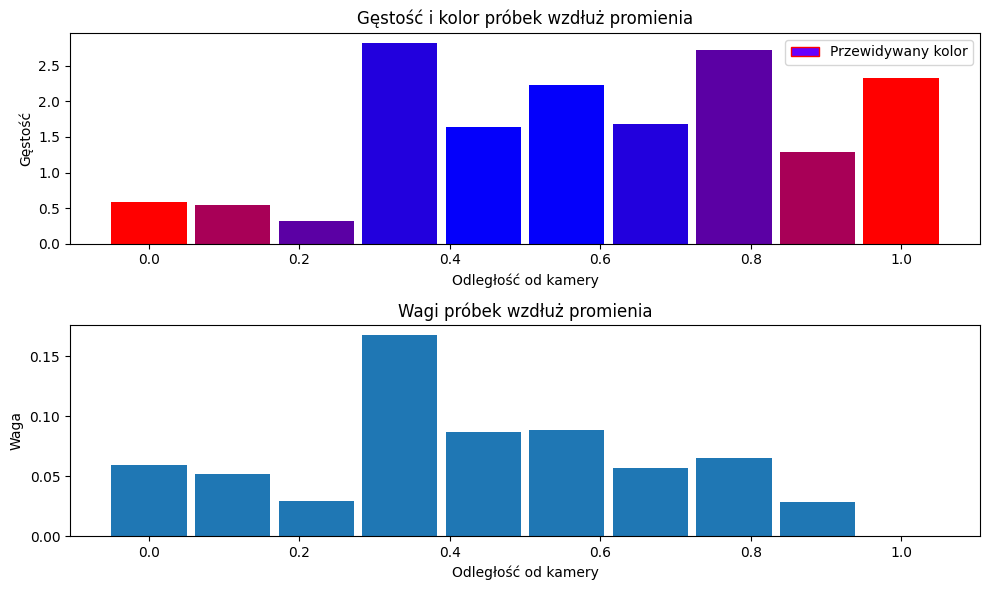

Wyrenderowany kolor promienia: [0.40119397 0.         1.        ]


In [68]:
# Utwórz pojedynczy promień z 10 punktami próbkowania.
N_samples = 10
z_vals = np.linspace(0, 1, N_samples)  # Pozycje próbek wzdłuż promienia.
ray_d = np.array([0, 0, 1])  # Kierunek promienia.

# Utwórz losowe kolory i gęstości dla każdego punktu próbkowania.
raw = np.random.rand(N_samples, 4)
raw[..., 3] = raw[..., 3] * 3  # Przekształć gęstości do zakresu [0, 3].

# Zdefiniuj dwa kolory.
color1 = np.array([1, 0, 0])  # Czerwony.
color2 = np.array([0, 0, 1])  # Niebieski.

# Normalizuj z_vals do zakresu [0, 1].
z_vals_normalized = (z_vals - np.min(z_vals)) / (np.max(z_vals) - np.min(z_vals))

# Utwórz sinusoidalne mapowanie gradientu koloru na podstawie odległości.
raw[..., :3] = color1[None, :] + (color2 - color1)[None, :] * np.sin(np.pi * z_vals_normalized)[:, None]

# Wyrenderuj kolor promienia.
rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs_single_ray(raw, z_vals, ray_d)

# Wykreśl punkty próbkowania.
plot_sample_points(z_vals, raw, weights, rgb_map)

### Proces trenowania

Trenowanie NeRF'a można przedstawić w następujących krokach:

1. Odpowienie przygotowanie danych. Bedziemy potrzebować wykonanych zdjęć wraz z pozcją kamery.
2. W każdej iteracji jest losowany zestaw promieni dla których bedzie liczony kolor
3. Dla każdego wylosowanego promienia jest obliczanych N wylosowanych próbek na całej jego długości
4. Z wylosowanych próbek za pomocą renderowania objętości jest obliczany kolor
5. Ostatnim krokiem jest obliczanie loss'u

Trenowanie modelu podstawowo, w rozszeniu i praktyce stosuje sie dodatkowo importance sampling, ktory teraz nie bedzie omawiany.

<br>

----
Loss:

$$ \Large L =  \sum_{r \in R} \Vert \hat{C}(r) - C(r) \Vert^2_2 $$

gdzie:

$R$ - zbiór promieni <br/>
$\hat{C}(r)$ - kolor wygenerowany przez sieć neuronową <br/>
$C(r)$ - kolor oczekiwany <br/>

----

## Usprawnienie modelu

#### Jedną z najwazniszych rzeczy jakie można zrobić to Fourier Feature

Operowanie na suchych współrzednych x,y,z przynosi słabe rezultaty w kontekście szczegółów i kolorów na obrazku, autorzy pracy powołując sie na innych badaczy dokonują następującej transformacji:

$$ \Large \gamma(p) = \left[ \sin(2^0 \pi p B), \cos(2^0 \pi p B), \sin(2^1 \pi p B), \cos(2^1 \pi p B), \dots, \sin(2^{L-1} \pi p B), \cos(2^{L-1} \pi p B) \right] $$

gdzie:

$p$ - znormalizowane współrzędne punktu<br>
$L$ - stała/zmienna mówiąca na ile par sinusów i cosinósów ma byż przemapowana każda współrzędna <br>
$B$ - macierz gausowska z rozkładu $N(\mu, \sigma^2)$ o wymiarach $3 \times L$ <br>

Poniższy przykład pokazuje jak może wygląda nauka z użyciem Fourier Feature i bez niego, gołym okiem widać na obrazku oraz na PSNR różnice

<div style="display: flex; justify-content: center;">
<img src="src/lion_none_gauss_v1.gif" width="2000" />
</div>
<figcaption style="display: flex; justify-content: center;">Fig.6 - porównanie z i bez Fourier Feature [3]</figcaption>

Należy jednak uważać, ponieważ nieodpowiednie dobranie parametrów może doprowadzić do pogorszenia jakości zdjeć, tyczy sie to parametru L

<div style="display: flex; justify-content: center;">
<img src="src/test_sweep_1e-4_5000_more_low.gif" width="2000" />
</div>
<figcaption style="display: flex; justify-content: center;">Fig.7 - Fourier Feature i neural tangent kernel [3]</figcaption>

## Rezultaty

<div>
<img src="src/res3.png" width="2000" />
</div>

<div>
<img src="src/res2.png" width="2000" />
</div>

<div>
<img src="src/res1.png" width="2000" />
</div>
<figcaption style="display: flex; justify-content: center;">Fig.8 - rezultaty [2]</figcaption>


## Podsumowanie i nasze wnioski

#### Podsumowanie:

NeRF jest w stanie generować fotorealistyczne obrazy 3D, na podstawie danych treningowych z rzeczywistych lub syntetycznych scen. W tym celu wykorzystuje głębokie sieci neuronowe, które modelują radiance field, czyli funkcję reprezentującą radiancję światła w trójwymiarowej przestrzeni. NeRF jest w stanie uwzględnić złożone efekty oświetleniowe i skomplikowane detale, takie jak cienie czy odblaski. Wystarczy jednorazowo zeskanować scenę, a potem już możemy obracać i przybliżać obiekt z dowolnej perspektywy. NeRF może tworzyć bardzo realistyczne obrazy 3D, które czasami są trudne do odróżnienia od prawdziwych scen.

Forier Feature jest bardzo ważnym elementem w procesie uczenia NeRF'a, dzięki niemu model jest w stanie nauczyć się szczegółów i kolorów na obrazku. Należy jednak uważać, ponieważ nieodpowiednie dobranie parametrów może doprowadzić do pogorszenia jakości zdjeć, tyczy sie to parametru L.

_Podsumowanie na podstawie zawartej bibliografii._

#### Nasze wnioski:
##### Zalety:

* Realistyczne renderowanie: NeRF może tworzyć bardzo realistyczne obrazy 3D, które są trudne do odróżnienia od prawdziwych scen.
* Jednorazowe skanowanie: Wystarczy jednorazowo zeskanować scenę, a potem już możemy obracać i przybliżać obiekt z dowolnej perspektywy.
* Głębia i szczegóły: NeRF jest w stanie uwzględnić złożone efekty oświetleniowe i skomplikowane detale, takie jak cienie czy odblaski.

##### Wady:

* Wymaga dużej ilości danych: Aby uzyskać dobre rezultaty, NeRF wymaga dużego zestawu danych treningowych, czyli wielu zdjęć danej sceny z różnych perspektyw.
* Wolne tempo przetwarzania: NeRF nie jest szybki. Generowanie obrazu z modelu NeRF może zająć nawet kilka minut, co na razie wyklucza wykorzystanie tej technologii w czasie rzeczywistym.
* Złożoność obliczeniowa: NeRF wymaga dużych mocy obliczeniowych i pamięci, co sprawia, że nie jest optymalny dla urządzeń o ograniczonych zasobach, takich jak telefony komórkowe.
* Trudności ze złożonymi scenami: Przy skomplikowanych scenach z elementami ruchu, takimi jak zmienna pogoda lub przechodnie, NeRF może mieć problemy z dokładnym odwzorowaniem rzeczywistości.



### Bibliografia

[1] https://www.matthewtancik.com/nerf <br>
[2] https://arxiv.org/pdf/2003.08934.pdf <br>
[3] https://bmild.github.io/fourfeat/